In [2]:
# SHASHANK KATHAVATE
# 2021530332
# ARTIFICIAL INTELLIGENCE - CS6364

The code can be run on GPU or CPU, however the cpu execution take longer. If there is no GPU available please use the same coed on google colab with the GPU enabled. The code requires the files "meta", "train" and "test" in the same directory to run. The outputs will be displayed on the jupyter notebook.

In [3]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn import *
from torch.optim import Adam
import pickle


In [4]:
def unpickle(inputFile):
    with open(inputFile, 'rb') as file:
        dict = pickle.load(file, encoding='bytes')
    return dict

metadata_path = 'meta'
metadata = unpickle(metadata_path)
superclassDict = dict(list(enumerate(metadata[b'coarse_label_names'])))

dataTrainPath = 'train'
dataTestPath = 'test'
# Read dictionary
dataTrainDict = unpickle(dataTrainPath)
dataTestDict = unpickle(dataTestPath)
# Get data (change the coarse_labels if you want to use the 100 classes)
dataTrain = dataTrainDict[b'data']
labelTrain = np.array(dataTrainDict[b'coarse_labels'])
dataTest = dataTestDict[b'data']
labelTest = np.array(dataTestDict[b'coarse_labels'])
xTrainSet = np.asarray(dataTrain).reshape(-1,3,32,32).astype('float32')
xTestSet = np.asarray(dataTest).reshape(-1,3,32,32).astype('float32')
yTrainSet = np.asarray(labelTrain)
yTestSet = np.asarray(labelTest)

#Normalize Data
xTrainSetNorm = xTrainSet -  xTrainSet.min()
xTrainSetNorm /= xTrainSet.max()

#normalizeData
xTestSet -= xTestSet.min()
xTestSet /= xTestSet.max()
xTestSe = xTestSet

print(xTrainSet.shape,labelTrain.shape)


(50000, 3, 32, 32) (50000,)


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x286e9b160>)

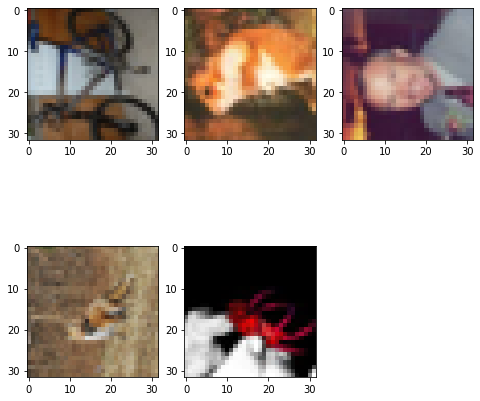

In [5]:
plt.figure(figsize=(8,8))
plt.subplot(231), plt.imshow(xTrainSetNorm[30].T)
plt.subplot(232), plt.imshow(xTrainSetNorm[60].T)
plt.subplot(233), plt.imshow(xTrainSetNorm[90].T)
plt.subplot(234), plt.imshow(xTrainSetNorm[120].T)
plt.subplot(235), plt.imshow(xTrainSetNorm[150].T)

In [6]:
xTrain,xValidation,yTrain,yValidation = train_test_split(xTrainSet,yTrainSet,test_size=0.1)

xTrain = xTrain.reshape(45000,3,32,32)
xValidation = xValidation.reshape(5000,3,32,32)
xValidation = torch.from_numpy(xValidation)
xTrain = torch.from_numpy(xTrain)
yTrain = yTrain.astype(int)
yValidation = yValidation.astype(int)
yTrain = torch.from_numpy(yTrain)
yValidation = torch.from_numpy(yValidation)
print(xTrain.shape,yTrain.shape,xValidation.shape,yValidation.shape)

torch.Size([45000, 3, 32, 32]) torch.Size([45000]) torch.Size([5000, 3, 32, 32]) torch.Size([5000])


In [7]:
class AlexNet(Module):
    def __init__(self):
        super().__init__()
        self.layer1 = Sequential(
            Conv2d(3, 32, kernel_size=5, stride=1, padding=0),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size = 3, stride = 2),
            Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size = 3, stride = 2),
            Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(96),
            ReLU(inplace=True),
            Conv2d(96, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            ReLU(inplace=True),
            Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size = 2, stride = 2))

        self.fc = Sequential(
            Dropout(0.5),
            Linear(288, 1024),
            ReLU(inplace=True),
            Dropout(0.5),
            Linear(1024, 512),
            ReLU(inplace=True),
            Linear(512, 100))
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [8]:
model = AlexNet()
optimizer = torch.optim.Adam(model.parameters(),lr=0.05)
lossFunc = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    lossFunc = lossFunc.cuda()
    
print(model)

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 32, kernel_size=(3, 3),

In [9]:
trainLossList = []
validationLossList = []

def trainData(epoch):
    model.train()
    xTrainData,yTrainData = Variable(xTrain), Variable(yTrain)
    xValidationData, yValidationData = Variable(xValidation),Variable(yValidation)

    if torch.cuda.is_available():
        xTrainData = xTrainData.cuda()
        yTrainData = yTrainData.cuda()
        xValidationData = xValidationData.cuda()
        yValidationData =yValidationData.cuda()
    else:
        print("NO GPU")
    optimizer.zero_grad()

    yPredTrain = model(xTrainData)
    ypredValidation = model(xValidationData)

    trainLoss = lossFunc(yPredTrain,yTrainData)
    validationLoss = lossFunc(ypredValidation,yValidationData)
    trainLossList.append(trainLoss.cpu().detach().numpy())
    validationLossList.append(validationLoss.cpu().detach().numpy())

    trainLoss.backward()
    optimizer.step()
    trainLossSum = trainLoss.item()
    if epoch%2 == 0:
        print('Epoch: ',epoch+1,'\t','loss: ',validationLoss)



In [10]:
totalEpochs = 10

for epoch in range(totalEpochs):
    trainData(epoch)


NO GPU
Epoch:  1 	 loss:  tensor(4.6077, grad_fn=<NllLossBackward0>)
NO GPU


<function matplotlib.pyplot.show(close=None, block=None)>

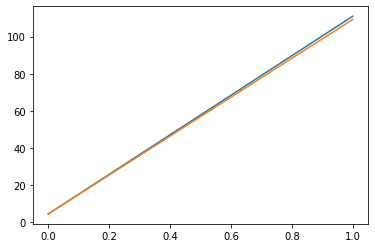

In [11]:
#plotting the losses
plt.plot(trainLossList,label = 'Training')
plt.plot(validationLossList,label='Validation')
plt.show

In [12]:
#Accuracy
def calcAccuracy(x,y):
    if torch.cuda.is_available():
        with torch.no_grad():
            yTrainPred = model(x.cuda())
            softmax = torch.exp(yTrainPred).cpu()
    
    else:
        yTrainPred = model(x)
        softmax = torch.exp(yTrainPred.detach())
        
    
    probability = list(softmax.numpy())
    predictions = np.argmax(probability, axis=1)
    # accuracy on training set
    return accuracy_score(y, predictions)


trainAccuracy = calcAccuracy(xTrain,yTrain)
validationAccuracy = calcAccuracy(xValidation,yValidation)

print("Train Accuracy= ",trainAccuracy)
print("Validation Accuracy= ",validationAccuracy)

Train Accuracy=  0.04997777777777778
Validation Accuracy=  0.0502


In [13]:
xTestSet = xTestSet.reshape(10000,3,32,32)
xTestSet = torch.from_numpy(xTestSet)
print(xTestSet.shape)

torch.Size([10000, 3, 32, 32])


['Beaver', 'Beaver', 'Beaver', 'Beaver', 'Beaver']


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x28b13aa40>)

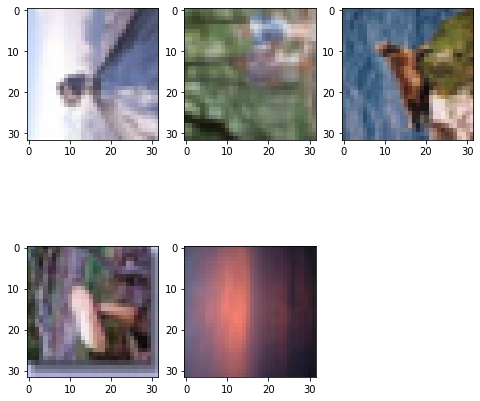

In [14]:
#Test set predicitons

if torch.cuda.is_available():
    with torch.no_grad():
        yTestPred = model(xTestSet.cuda())
        softmax = torch.exp(yTestPred).cpu()
else:
    yTestPred = model(xTestSet)
    softmax = torch.exp(yTestPred.detach())
    
probability = list(softmax.numpy())
predictions = np.argmax(probability, axis=1)
labelDict = {
    0:"Beaver",1:"Dolphin",2:"Otter",3:"Seal",4:"Whale",
    5:"Aquarium Fish",6:"Flatfish",7:"Ray",8:"Shark",9:"Trout",
    10:"Orchids",11:"Poppies",12:"Roses",13:"Sunflowers",14:"Tulips",
    15:"Bottles",16:"Bowls",17:"Cans",18:"Cups",19:"Plates",
    20:"Apples",21:"Mushrooms",22:"Oranges",23:"Pears",24:"Sweet Peppers",
    25:"Clock",26:"Computer Keyboard",27:"Lamp",28:"Telephone",29:"Television",
    30:"Bed",31:"Chair",32:"Couch",33:"Table",34:"Wardrobe",
    35:"Bee",36:"Beetle",37:"Butterfly",38:"Caterpillar",39:"Cockroach",
    40:"Bear",41:"Leopard",42:"Lion",43:"Tiger",44:"Wolf",
    45:"Bridge",46:"Castle",47:"House",48:"Road",49:"Skyscraper",
    50:"Cloud",51:"Forest",52:"Mountain",53:"Plain",54:"Sea",
    55:"Camel",56:"Cattle",57:"Chimpanzee",58:"Elephant",59:"Kangaroo",
    60:"Fox",61:"Porcupine",62:"Possum",63:"Racoon",64:"Skunk",
    65:"Crab",66:"Lobster",67:"Snail",68:"Spider",69:"Worm",
    70:"Baby",71:"Boy",72:"Girl",73:"Man",74:"Woman",
    75:"Crocodile",76:"Dinasaur",77:"Lizard",78:"Snake",79:"Turtle",
    80:"Hamster",81:"Mouse",82:"Rabbit",83:"Shrew",84:"Squirrel",
    85:"Maple",86:"Oak",87:"Palm",88:"Pine",89:"Willow",
    90:"Bicycle",91:"Bus",92:"MotorCycle",93:"Pickup Truck",94:"Train",
    95:"Lawn-mover",96:"Rocket",97:"Street car",98:"Tank",99:"Tracktor"
}
#Results for the 10000 test data images. The above dictionary represents the classification label for the data.
predictions = [labelDict[i] for i in predictions]
#First 5 Predictions
print(predictions[:5])
plt.figure(figsize=(8,8))
plt.subplot(231), plt.imshow(xTestSe[0].T)
plt.subplot(232), plt.imshow(xTestSe[1].T)
plt.subplot(233), plt.imshow(xTestSe[2].T)
plt.subplot(234), plt.imshow(xTestSe[3].T)
plt.subplot(235), plt.imshow(xTestSe[4].T)